```bash
pip install seaborn
```

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Need to manually delete the `__MACOSX` directory

In [21]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '__MACOSX')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [22]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [23]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [24]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [25]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [26]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [27]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

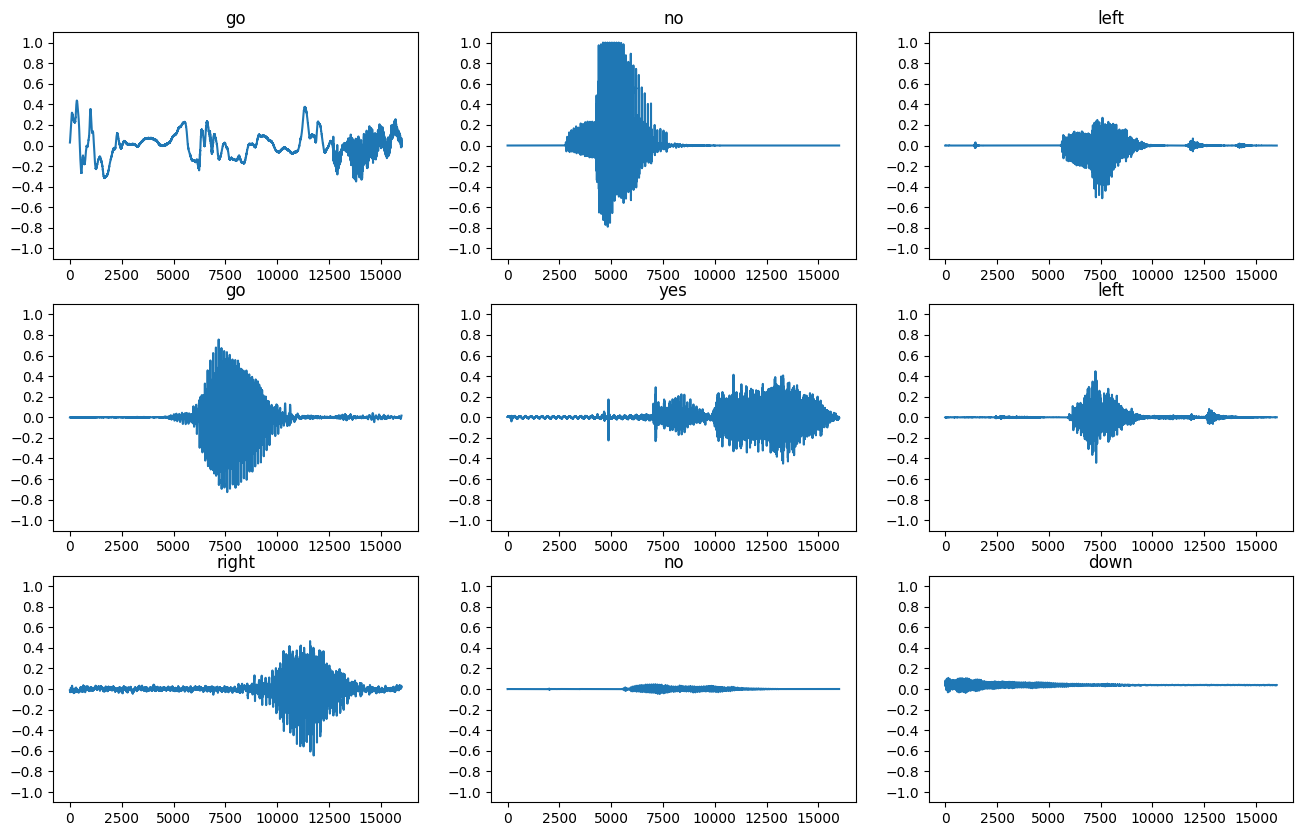

In [28]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [29]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [30]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [31]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

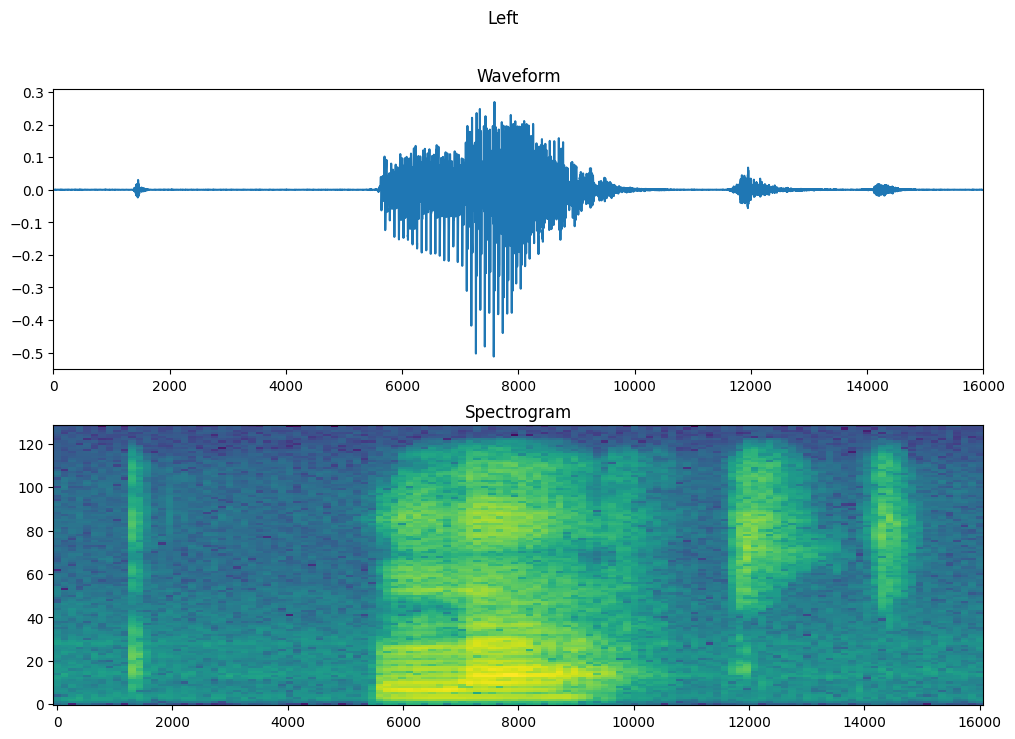

In [32]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [33]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [35]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

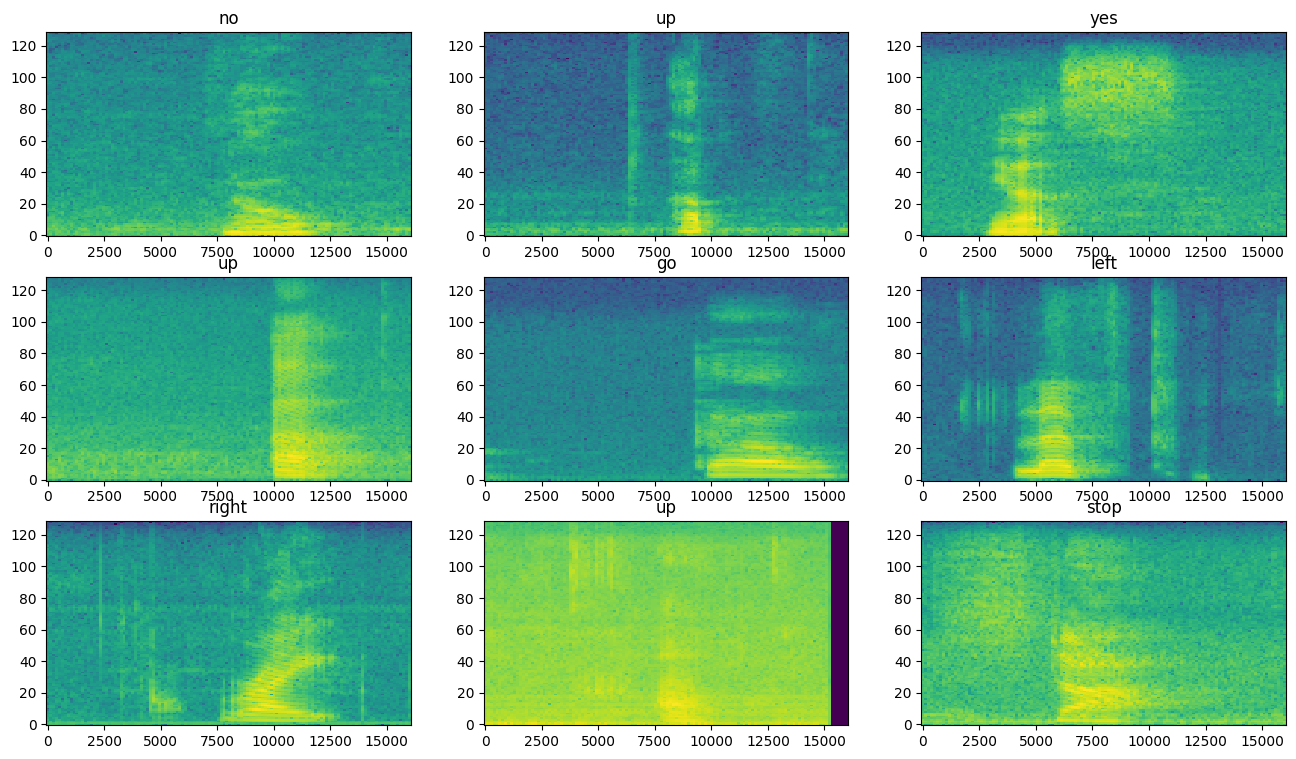

In [36]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [37]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [38]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2025-03-04 17:12:43.567610: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [40]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2877 - loss: 1.8960 - val_accuracy: 0.6263 - val_loss: 1.2511
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5698 - loss: 1.2326 - val_accuracy: 0.7513 - val_loss: 0.8948
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6897 - loss: 0.8816 - val_accuracy: 0.7617 - val_loss: 0.7222
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7413 - loss: 0.7286 - val_accuracy: 0.8034 - val_loss: 0.6560
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7924 - loss: 0.5930 - val_accuracy: 0.8021 - val_loss: 0.5889
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8000 - loss: 0.5567 - val_accuracy: 0.8346 - val_loss: 0.5487
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8355 - loss: 0.4711 - val_accuracy: 0.8320 - val_loss: 0.5073
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8598 - loss: 0.4183 - val_accu

Text(0, 0.5, 'Accuracy [%]')

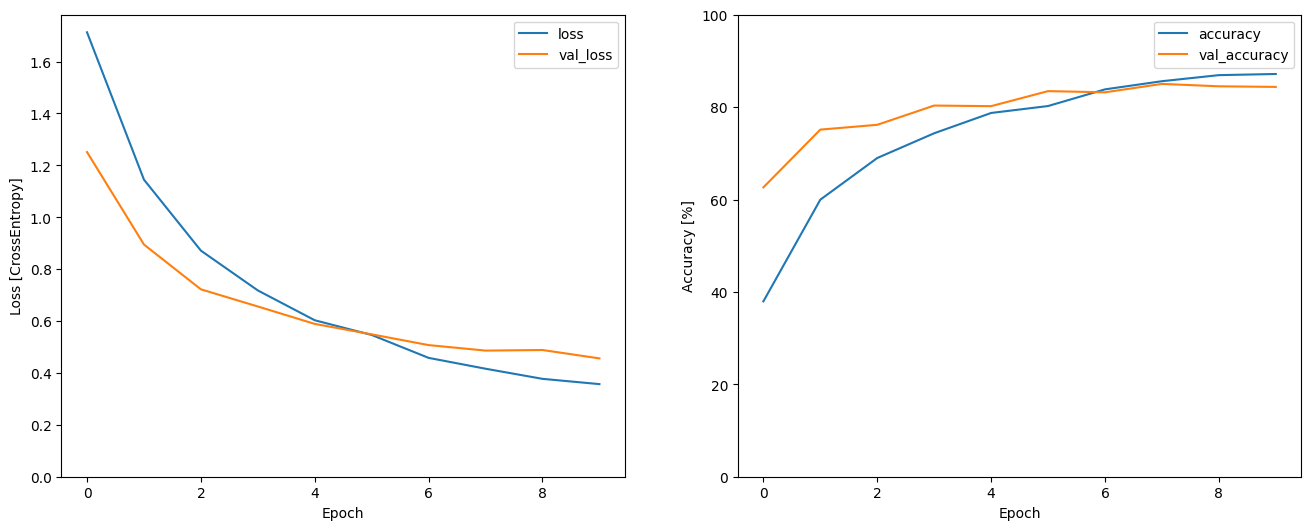

In [41]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [42]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8429 - loss: 0.4437


{'accuracy': 0.854567289352417, 'loss': 0.43304604291915894}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


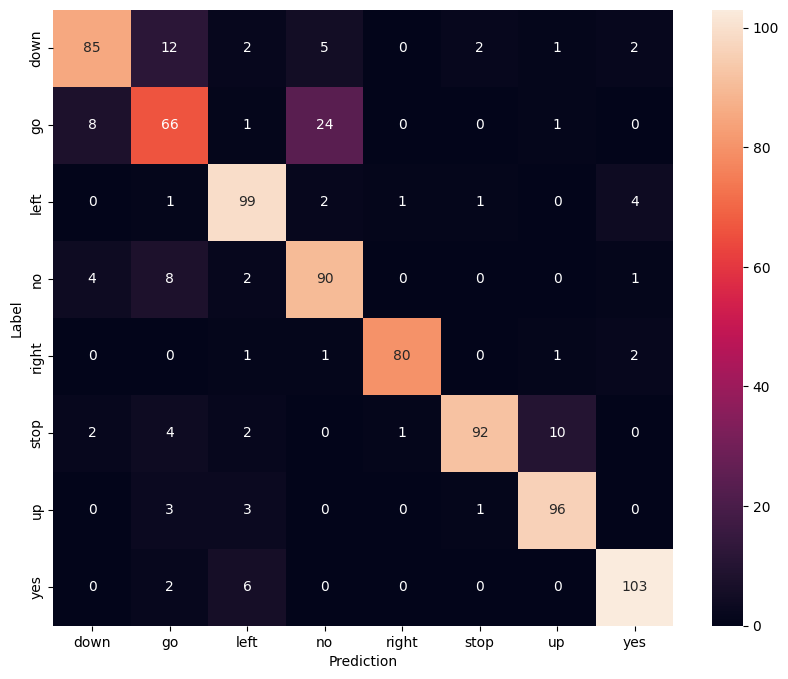

In [43]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Test using live audio recording

In [44]:
import pyaudio
import wave
from io import BytesIO

def record_audio_to_variable(record_seconds=5, 
                             rate=44100, 
                             chunk=1024, 
                             channels=1):
    """
    Records audio from the default microphone for `record_seconds` seconds
    and returns the audio data as WAV bytes (i.e., a complete WAV file in memory).
    """
    FORMAT = pyaudio.paInt16
    audio_interface = pyaudio.PyAudio()

    # Open the microphone stream
    stream = audio_interface.open(
        format=FORMAT,
        channels=channels,
        rate=rate,
        input=True,
        frames_per_buffer=chunk
    )

    print("Recording...")
    frames = []

    # Capture data from the mic for the specified duration
    for _ in range(int(rate / chunk * record_seconds)):
        data = stream.read(chunk)
        frames.append(data)

    print("Done recording!")

    # Stop & close the stream
    stream.stop_stream()
    stream.close()
    audio_interface.terminate()

    # Combine all frames into a single bytes object and write to an in-memory WAV
    wav_io = BytesIO()
    with wave.open(wav_io, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(audio_interface.get_sample_size(FORMAT))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))

    # Reset buffer pointer to start
    wav_io.seek(0)

    # Return the entire WAV file as bytes
    return wav_io.read()


In [45]:
from scipy.io.wavfile import read as wav_read
import io
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [46]:
def get_audio(seconds):
    output = record_audio_to_variable(record_seconds=seconds)
    riff_chunk_size = len(output) - 8

    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))
    return audio, sr

In [59]:
# Say a keyword
# ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
audio_loud, sr_loud = get_audio(2)
print("DONE")

Recording...
Done recording!
DONE


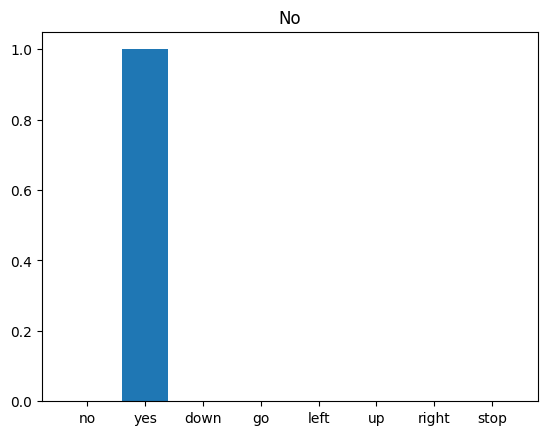

In [61]:
waveform = audio_loud
x = tfio.audio.spectrogram(audio_loud/1.0, nfft=2048, window=len(audio_loud), stride=int(sr_loud * 0.008))

x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

## Convert to TFLite

- Download and unzip [tensorflow-2.18.0](https://github.com/tensorflow/tensorflow/archive/v2.18.0.zip) source code. 
- Use the path in the cell below

In [64]:
import sys
sys.path.append("/Users/lngo/workspace/tensorflow-2.18.0/tensorflow/examples/speech_commands/")
import models
import input_data

In [ ]:
WANTED_WORDS = "down,go,left,no,right,stop,up,yes"
# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.
number_of_labels = WANTED_WORDS.count(',') + 1
number_of_total_labels = number_of_labels + 2 # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))
SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples

# Constants which are shared during training and inference
PREPROCESS = 'micro'
WINDOW_STRIDE = 20
MODEL_ARCHITECTURE = 'tiny_conv'

# Constants for training directories and filepaths
DATASET_DIR =  'dataset/'
LOGS_DIR = 'logs/'
TRAIN_DIR = 'train/' # for training checkpoints and other files.

# Constants for inference directories and filepaths
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = os.path.join(MODELS_DIR, 'model.pb')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
FLOAT_MODEL_TFLITE = os.path.join(MODELS_DIR, 'float_model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')
SAVED_MODEL = os.path.join(MODELS_DIR, 'saved_model')

# Constants for Quantization
QUANT_INPUT_MIN = 0.0
QUANT_INPUT_MAX = 26.0
QUANT_INPUT_RANGE = QUANT_INPUT_MAX - QUANT_INPUT_MIN

# Constants for audio process during Quantization and Evaluation
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0.8
BACKGROUND_VOLUME_RANGE = 0.1
TIME_SHIFT_MS = 100.0

# URL for the dataset and train/val/test split
DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
#DATA_URL = 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10


In [ ]:
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
audio_processor = input_data.AudioProcessor(
    DATA_URL, DATASET_DIR,
    SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
    WANTED_WORDS.split(','), VALIDATION_PERCENTAGE,
    TESTING_PERCENTAGE, model_settings, LOGS_DIR)

In [ ]:
with tf.Session() as sess:
# with tf.compat.v1.Session() as sess: #replaces the above line for use with TF2.x
  float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

  converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.inference_input_type = tf.lite.constants.INT8
  # converter.inference_input_type = tf.compat.v1.lite.constants.INT8 #replaces the above line for use with TF2.x   
  converter.inference_output_type = tf.lite.constants.INT8
  # converter.inference_output_type = tf.compat.v1.lite.constants.INT8 #replaces the above line for use with TF2.x
  def representative_dataset_gen():
    for i in range(100):
      data, _ = audio_processor.get_data(1, i*1, model_settings,
                                         BACKGROUND_FREQUENCY, 
                                         BACKGROUND_VOLUME_RANGE,
                                         TIME_SHIFT_MS,
                                         'testing',
                                         sess)
      flattened_data = np.array(data.flatten(), dtype=np.float32).reshape(1, 1960)
      yield [flattened_data]
  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)